<a href="https://colab.research.google.com/github/KoMurase/movie_research_2/blob/master/reserch_moviebowl_TextCNN_LGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

方針:SF映画に含まれるいくつかのタイトルに対してスコアに対するクラス分類を行う<br> 

映画レビュー20000件を取ってくる(理想はいい感じでスコアがばらけてる感じ) <br> 
各レビューに前処理をした後，TextCNN,LightGBMなどで分類を行う<br>
後評価も別途行いたい（feature_importanceなど) <br> 





In [1]:
!pip install japanize-matplotlib
!apt-get -q -y install swig 
!apt-get install mecab
!apt-get install libmecab-dev
!apt-get install mecab-ipadic-utf8
!pip install mecab-python3
!pip install unidic-lite
#日本語フォントのインストール　（wordcloudなどで可視化するため）
!apt-get -y install fonts-ipafont-gothic

!pip install neologdn 
#半角を全角に変換
!pip install mojimoji

     |████████████████████████████████| 4.1MB 4.8MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.2-cp36-none-any.whl size=4120193 sha256=df1f4550404ffdff0b52237280ccb53b87a3a7f77464d7448d2c80b1de08492a
  Stored in directory: /root/.cache/pip/wheels/9c/f9/fc/bc052ce743a03f94ccc7fda73d1d389ce98216c6ffaaf65afc
Successfully built japanize-matplotlib
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 11 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.1

In [2]:
import numpy as np
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline  

import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(1)
random_state = 42

cuda


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
path = "/content/drive/My Drive/movie_research/review_csv/SF_data.csv"
data = pd.read_csv(path) 

In [4]:
#data = data.sample(20000)
data = data[data["title"] != "レディ・プレイヤー1|Ready Player One"]

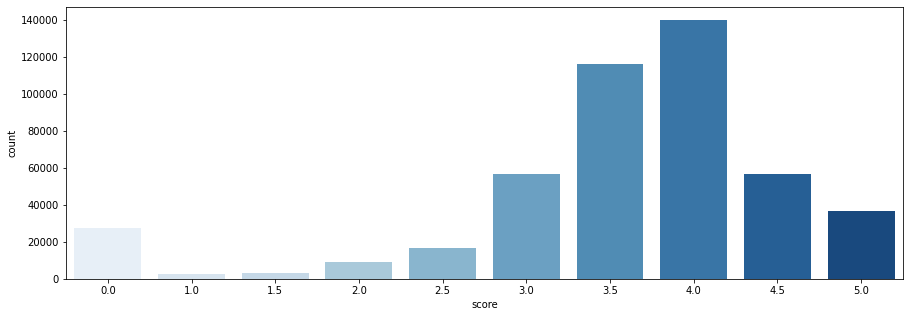

In [5]:
#数値カラムに変換する
def prepro(df, col):
  df = df.copy() 
  df[col] = df[col].replace('-','0') #回答してない人を0埋め
  df[col] = df[col].astype(float)

  return df

data = prepro(data, "score")
data["score"] = data["score"]*2.0
data["score"] = data["score"].round() / 2.0
plt.figure(figsize=(15, 5))
sns.countplot(data["score"].sort_values(), palette='Blues')

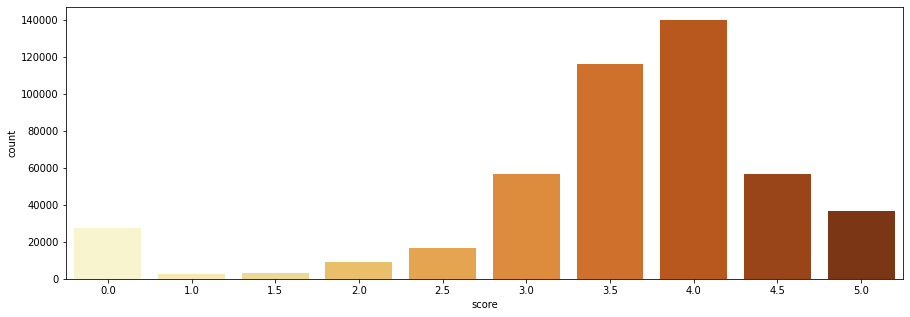

In [6]:
plt.figure(figsize=(15, 5))
sns.countplot(data["score"].sort_values(), palette='YlOrBr')

In [13]:
data["review"].sample(1).apply(lambda x: len(x))

62337    134
Name: review, dtype: int64

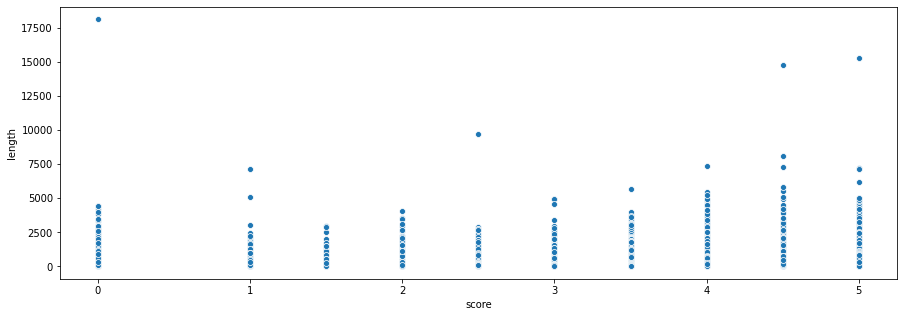

In [14]:
data["length"] = data["review"].apply(lambda x: len(x))
plt.figure(figsize=(15, 5))
sns.scatterplot(x=data["score"].sort_values(), y=data["length"], palette='YlOrBr')

やたら文章長い人(外れ値)とみなして省いて良いかも

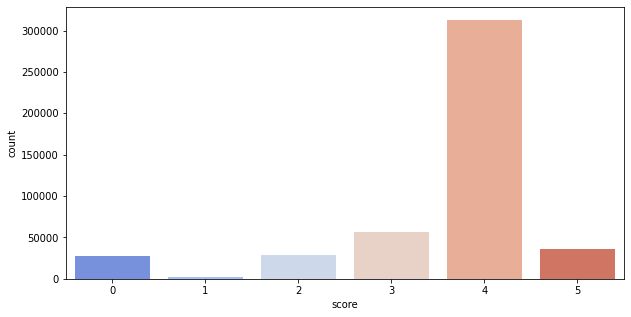

In [15]:
#data["score"] = data["score"].round().astype(int)

plt.figure(figsize=(10, 5))
sns.countplot(data["score"].round().astype(int).sort_values(), palette='coolwarm')

In [16]:
data["time"] = pd.to_datetime(data["time"])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]),
 <a list of 98 Text major ticklabel objects>)

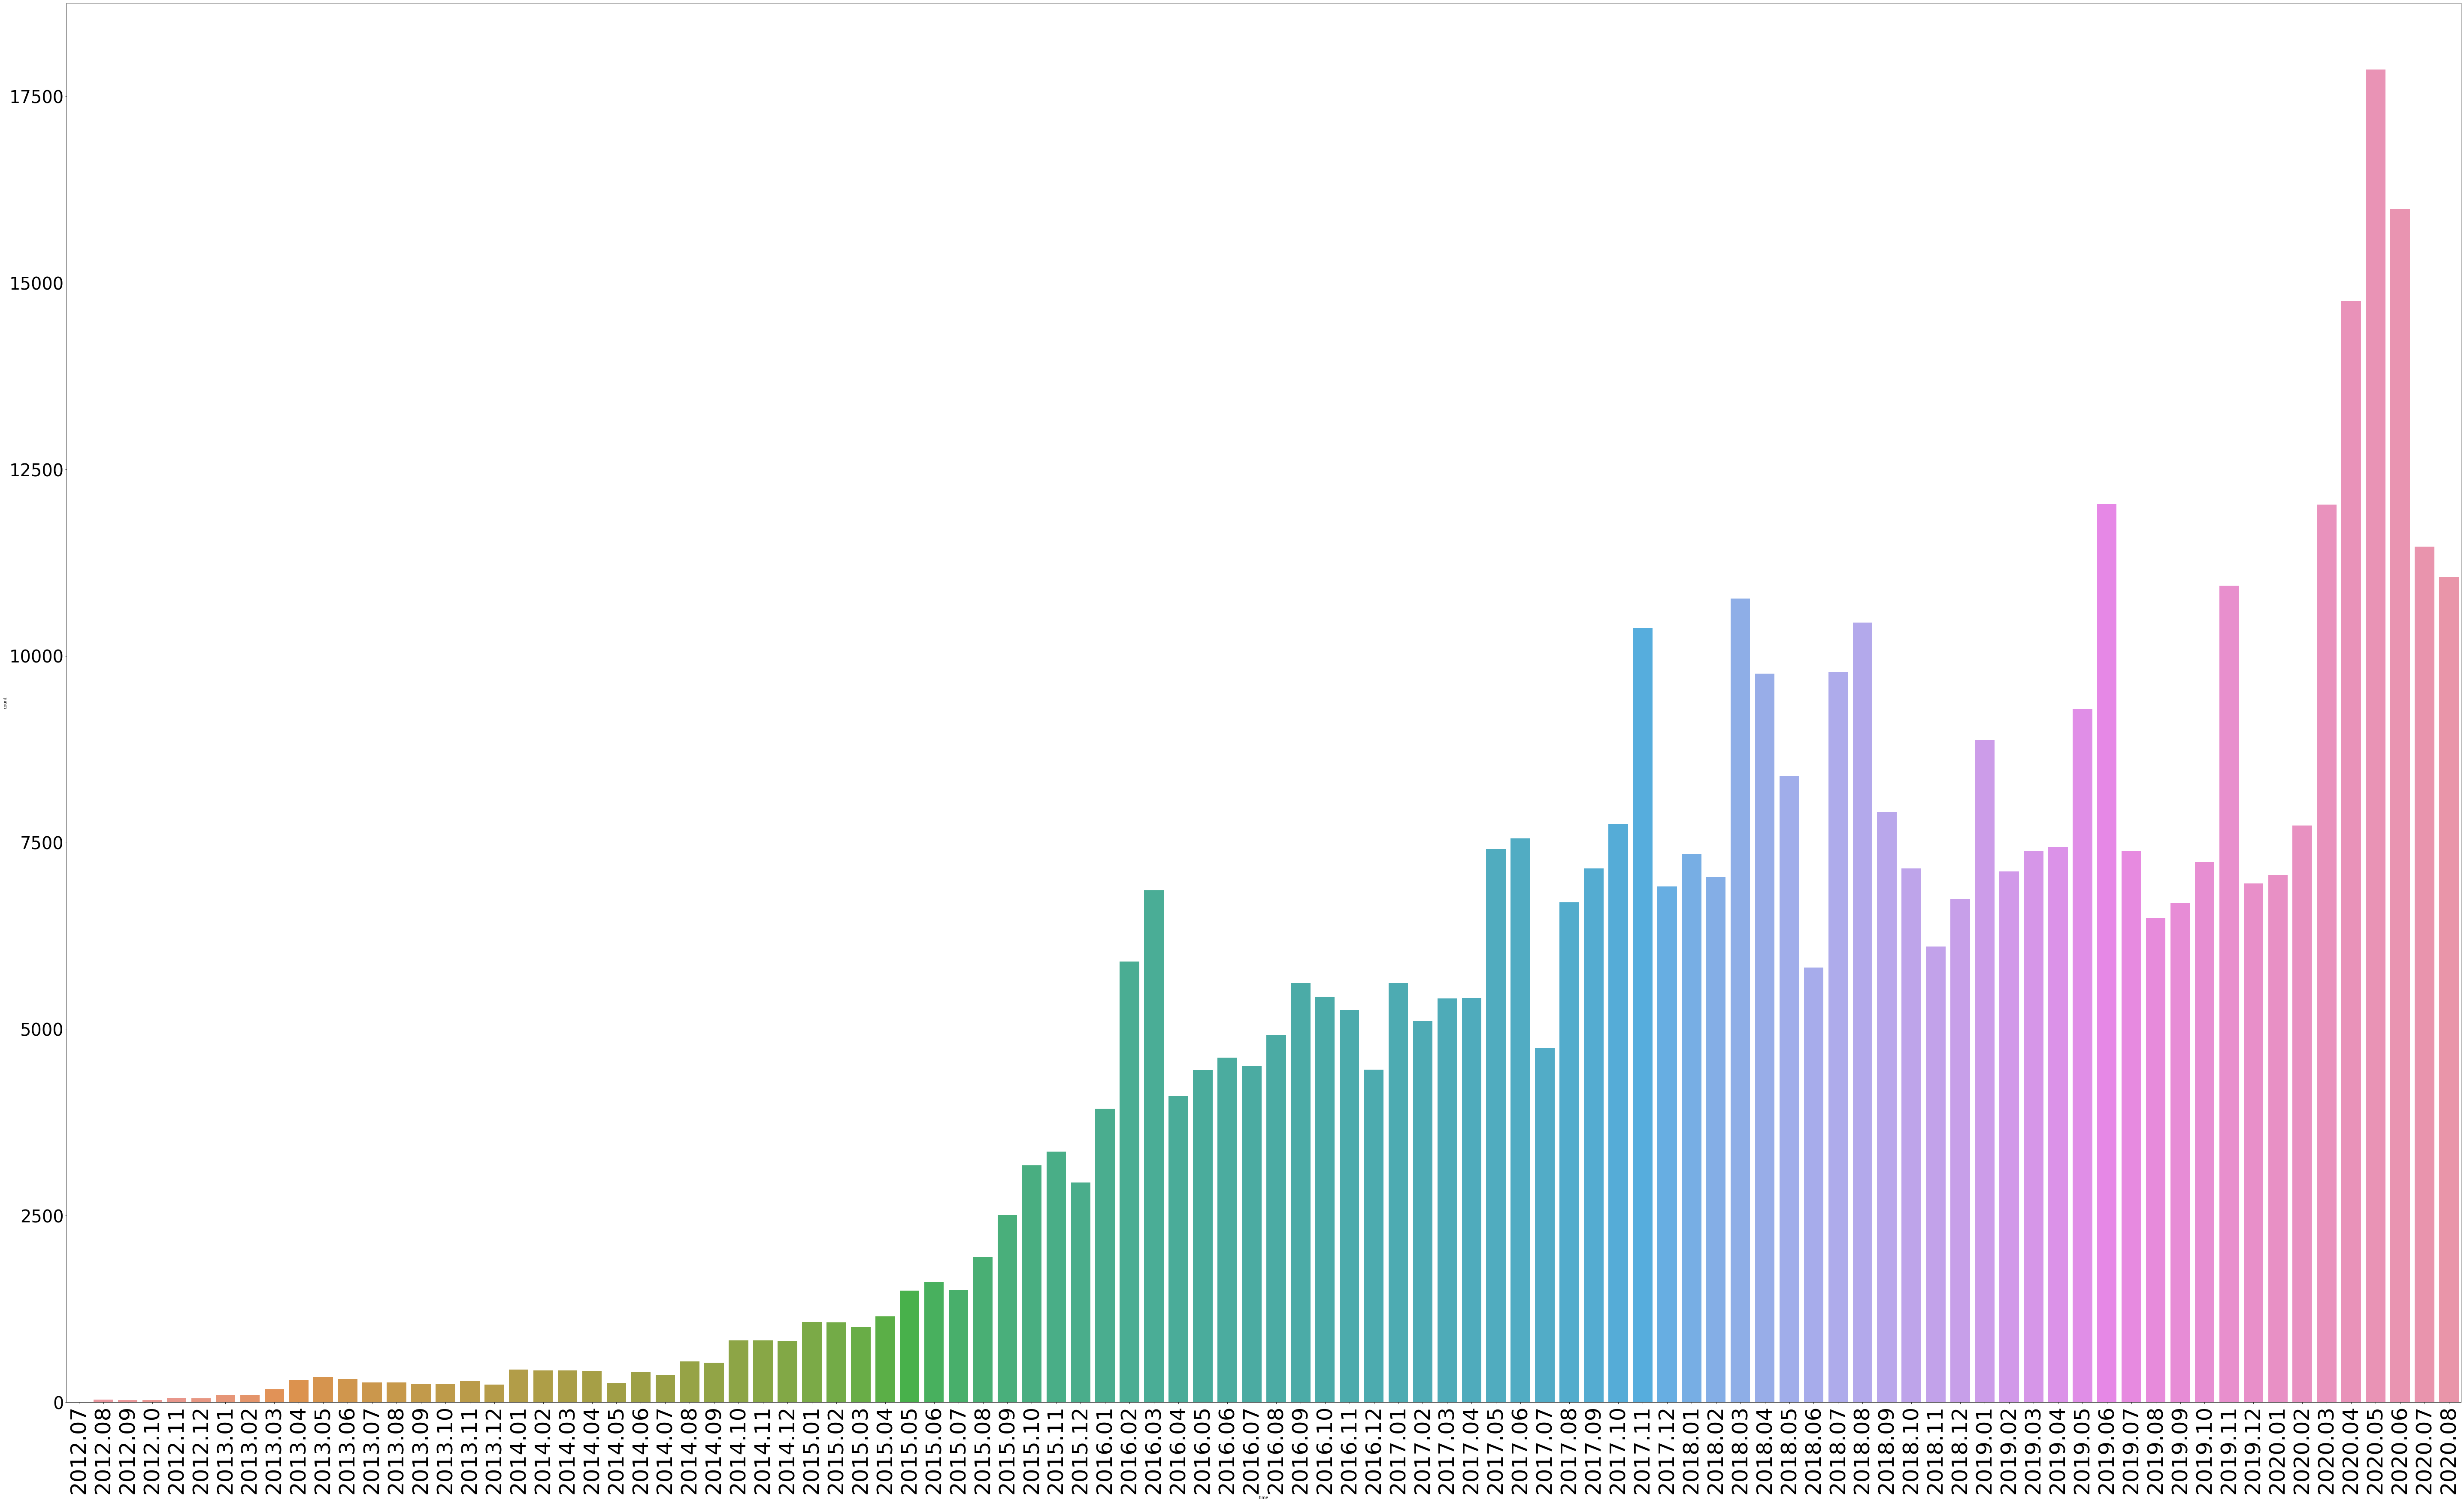

In [17]:
plt.figure(figsize=(100, 60))
sns.countplot(x=data["time"].dt.strftime('%Y.%m') )
plt.xticks(fontsize=50) #x軸のメモリサイズの拡大
plt.yticks(fontsize=40)
plt.xticks(rotation=90) #y軸ラベルを縦に表示 

取得先のサイトの知名度が上がっているのがわかる

In [18]:
#うまく抽出できるかわからないけど20000件を抽出する
data = data.sample(20000)

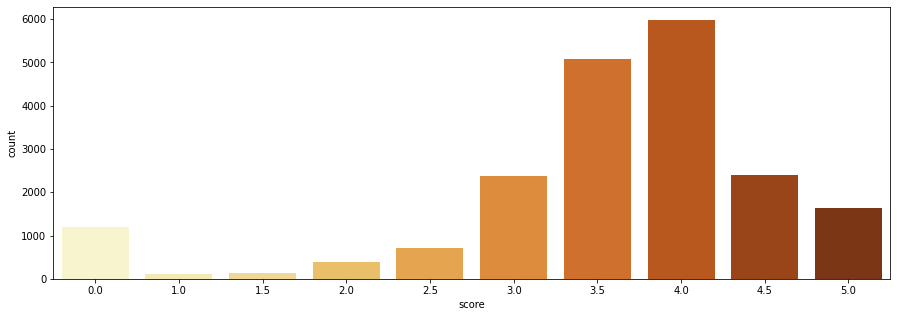

In [19]:
plt.figure(figsize=(15, 5))
sns.countplot(data["score"].sort_values(), palette='YlOrBr')

In [20]:
import neologdn 
import string 
import mojimoji 
import re 

def text_preprocess(text):

  text = neologdn.normalize(text)
  #URLを除去する
  text = re.sub(
      r'(http|https)://([-\w]+\.)+[-\w]+(/[-\w./?%&=]*)?', 
      "",
      text)
  #全角から半角に
  text = mojimoji.zen_to_han(text) 

  #3D,2Dを残したい
  text = text.replace('3D','三次元')
  text = text.replace('2D','二次元')

  #数字をすべて0に置換 
  text = re.sub(r'\d+', '0', text)

  #string.punctuationの除去
  table = str.maketrans('', '', string.punctuation)
  text = text.translate(table) 

  text = text.replace("｡",'')
  text = text.replace("。",'')
  text = text.replace("，",'')
  text = text.replace(",",'')
  text = text.replace("、",'')
  text = text.replace("､",'')
  text = text.replace("…",'')
  text = text.replace("･",'')
  

  # 【】の除去
  text = re.sub(r'[【】]', '', text)
  # （）の除去
  text = re.sub(r'[（）()]', '', text)
  # ［］の除去
  text = re.sub(r'[［］\[\]]', '', text)
  #アルファベットをの大文字を小文字に変換
  text = text.lower()

  #改行コードの除去
  text = text.replace('\n', '')
  text = text.replace('\r\n','')
  
  #空白を除去
  #全角スペース
  text = text.replace('\u3000','')
  #タブキー
  text = text.replace('\t','')
  #半角
  #text = re.sub(r' ','', text) →英字幕などの指摘もあるため後で行う
  
  return text 

In [21]:
!pip install emoji 
!pip install nagisa 
#!pip install unicodedata 

import emoji
import nagisa

def delete_emoji(text):
  target_list = [w for w in text if w in emoji.UNICODE_EMOJI]
  for trg in target_list:
    text = text.replace(trg, "")
  return text

     |████████████████████████████████| 51kB 2.6MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49716 sha256=781763caa8debbc5ef3e24bdb960364cc684bce4b587cc8e1579e3b58ccd47db
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji
     |████████████████████████████████| 21.5MB 1.3MB/s 
     |████████████████████████████████| 28.1MB 112kB/s 


In [22]:
data["review"] = data["review"].apply(text_preprocess) 
data["review"] = data["review"].apply(delete_emoji)

In [23]:
import MeCab
def mecab_dokuritugo(text):
  tagger = MeCab.Tagger() 
  tagger.parse('')
  node = tagger.parseToNode(text) 
  word_list = [] 
  while node: 
    pos = node.feature.split(",")[0] ### 単語の品詞を抽出
    if pos in ["動詞","形容詞"]:
      ### 動詞,形容詞の原型を抽出 
      ### [6]は原型がカタカナになって返ってくる
      word = node.feature.split(",")[7]  
      word_list.append(word) 

    elif pos in ["名詞"]: ### 名詞はそのまま
      word = node.surface 
      word_list.append(word)
    node = node.next
  return " ".join(word_list)

In [24]:
data["review_tokenize"] = data["review"].apply(mecab_dokuritugo)

In [47]:
print(data["review_tokenize"].sample(5) )

51522     記録 最後 泣く 辛い 長い 疲れる 最後 よし 成る 最初 仲間 集まる とこ come ...
404198                                  全体 為る 面白い ｴｰｼﾞｪﾝﾄ o
82918     0 回 見る 成る ﾗｽﾄ 伏線 回収 やばい 時 乗る 成る 俳優 陣 豪華 高い 映画 ...
139367    曲 使う 最高 of 最高 ﾖﾝﾄﾞｩ 良い 前作 ﾊﾟﾊﾟｻｲﾃｰ 有る 結局 ところ 家...
238003    原作 知る 記憶 操作 言う ｱｲﾃﾞｱ 面白い 生かす 感ずる 中盤 銃 向け合う ｼｰﾝ...
Name: review_tokenize, dtype: object


In [59]:
data[data.index==404198]

,title,name,time,review,score,URL,length,review_tokenize
404198,メン・イン・ブラック：インターナショナル|Men in Black International,オタク顔おじさんの感想・評価,2020-05-03 22:54:00,全体的にざっくりしてたけどまぁまぁおもろいっすｴｰｼﾞｪﾝﾄoがすき,3.0,https://filmarks.com//movies/79733?page=39,34,全体 為る 面白い ｴｰｼﾞｪﾝﾄ o


In [53]:
data.loc[462118]

title                            時計じかけのオレンジ|A Clockwork Orange
name                                               はーにゃんの感想・評価
time                                       2015-05-10 11:41:00
review                         映像音楽ｽﾄｰﾘｰすべて最高古い映画なのに全然そう感じさせない
score                                                        4
URL                https://filmarks.com//movies/25464?page=919
length                                                      37
review_tokenize                   映像 音楽 ｽﾄｰﾘｰ すべて 最高 古い 映画 感ずる
Name: 462118, dtype: object

In [55]:
data[data["name"] == 'はーにゃんの感想・評価']

,title,name,time,review,score,URL,length,review_tokenize
410841,リミットレス|Limitless,はーにゃんの感想・評価,2016-09-24 03:20:00,脳を活性化させる薬を飲んでiqを上げ株や大金を稼ぐ話こんな薬ほしい笑ﾗｽﾄは薬がなくなっても...,3.5,https://filmarks.com//movies/10297?page=137,91,脳 活性 為る 薬 飲む iq 上げる 株 大金 稼ぐ 話 薬 欲しい 笑 ﾗｽﾄ 薬 無く...
462118,時計じかけのオレンジ|A Clockwork Orange,はーにゃんの感想・評価,2015-05-10 11:41:00,映像音楽ｽﾄｰﾘｰすべて最高古い映画なのに全然そう感じさせない,4.0,https://filmarks.com//movies/25464?page=919,37,映像 音楽 ｽﾄｰﾘｰ すべて 最高 古い 映画 感ずる
